In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:////Users/ylsstudent/Documents/Data_Analytics_Bootcamp/Module_10_Advanced_SQL/sqlalchemy-challenge/Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/7q/p5_hth2d0mjcsb3ltyq5chtm0000gn/T/ipykernel_47578/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [26]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

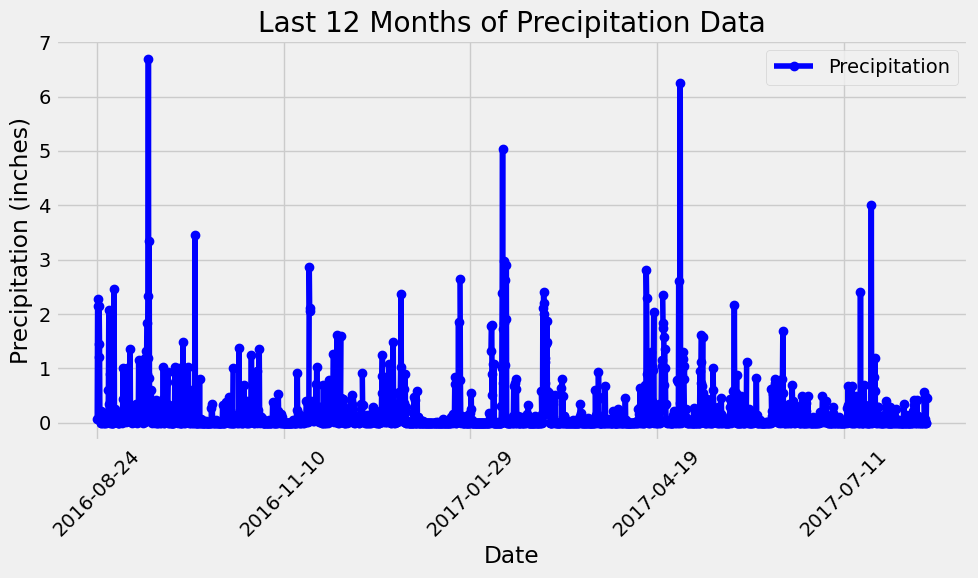

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=["Date", "Precipitation"])


# Sort the dataframe by date
precip_df = precip_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x="Date", y="Precipitation", figsize=(10, 6), marker='o', linestyle='-', color='b')
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Last 12 Months of Precipitation Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [60]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label("count"))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  # First station in the list

temp_stats = (
    session.query(
        func.min(Measurement.tobs).label("min_temp"),
        func.max(Measurement.tobs).label("max_temp"),
        func.avg(Measurement.tobs).label("avg_temp")
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

# Extract and display the results
min_temp, max_temp, avg_temp = temp_stats[0]

print(f"Station {most_active_station} - Min Temp: {min_temp}, Max Temp: {max_temp}, Avg Temp: {avg_temp}")

Station USC00519281 - Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


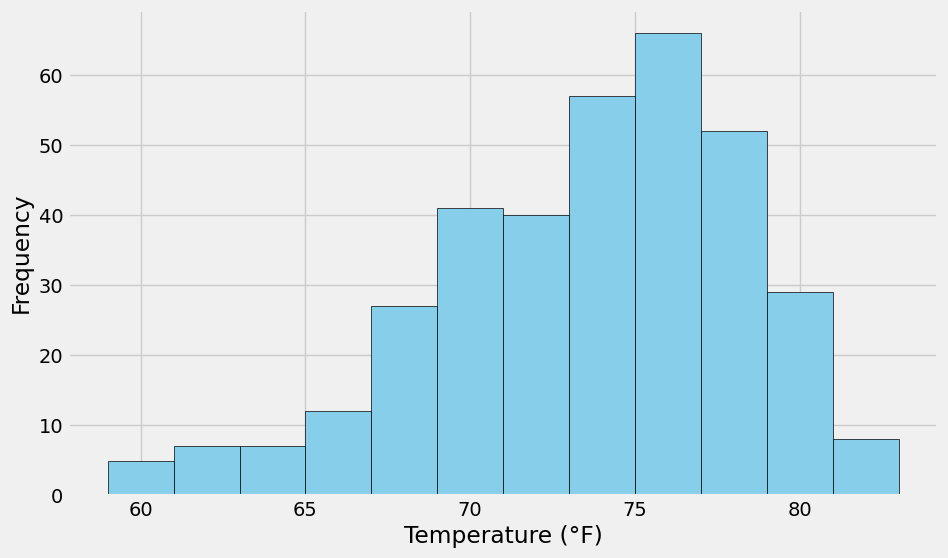

In [66]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(func.max(Measurement.date)).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date - dt.timedelta(days=365)

temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

temperatures = [temp[0] for temp in temperature_data]

plt.figure(figsize = (10, 6))
plt.hist(temperatures, bins = 12, edgecolor = 'black', color = 'skyblue')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [68]:
# Close Session
session.close()